In [4]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np



# Let's consider to start parameters and functions for the IAXO 

#Set some useful constant

frommtoeV = 1/(1.97e-7) # from meter to eV^-1

K_2_keV = 8.617333262e-5/1e3 # convert Kelvin to keV
cm_2_keV = 1.0/(1e6*1.9732e-14) # convert cm to keV^-1
fsc = 1.0/137.036 # fine structure constant
amu_grams = 1.66054e-24 # amu in grams
AU_cm = 100*1.495978707e11 # cm
Rsol_keV = 696340*1000*100*cm_2_keV
keV_2_s = 1000/6.5821e-16

L = 20 * frommtoeV *1e3 #length of the magnet in keV^-1
epsilonD = 0.7 # efficiency for the detector
epsilonT = 0.8 # efficiency for the telescope
S = 2.26 * frommtoeV**2 * 1e6 # total cross-section area for the helioscope in keV^-2
fromGtokeV2 = 1.953e-2 * 1e-6 # from Gauss to keV^2

def ProbabilityOfConversion(Ea, B, ma): # B is the magnetic field, ma the mass of the axion and Ea its energy
    # note: we factorized out the coupling axion-photon g
    q = ma**2 /(2*Ea)  # q --> momentum transfer
    if ma == 0:
        return L**4 * B**2 /4
    else:
        return (B/q)**2 * np.sin(q * L/2)**2


In [7]:
# We want to compute the LP flux 

# Load Saclay data
r,M,T,rho,ne,wp,k_S = np.loadtxt('saclaymodel.txt',unpack=True)

def MagneticFieldModel(r, Brad): # give the magnetic field in Gauss
    # we leave the normalization of the radiative zone varying
    
    # Model 3: from https://arxiv.org/pdf/astro-ph/0203107.pdf
    r0_12 = 0.712
    lamb = 10*r0_12 + 1
    dtach = 0.02
    r0_31 = 0.96
    douter  = 0.035
    if r < (r0_12 - dtach) :
        return(1+lamb)* (1+1/lamb)**lamb * Brad*(r/r0_12)**2 *(1-(r/r0_12)**2.0)**lamb
    elif abs(r-r0_12) < dtach:
        return 50.0e4*fromGtokeV2*(1-((r-r0_12)/dtach)**2.0)
    elif abs(r-r0_31)<douter:
        return 3e4*fromGtokeV2*(1-((r-r0_31)/douter)**2.0)
    else:
        return 0
    
gag = 1e-10 # GeV^-1
gagkeV = gag/1e6

# We define the plasmon flux without the coupling axion-photon that we can factorize out
# in the final number of photons detected by IAXO

def LplasmonFlux(omegavals,r,Brad,T,k_S,wp):
    Brad = Brad*fromGtokeV2  # B must be in Gauss, then we get it in keV^2
    rkeV = r*Rsol_keV
    nvals = np.size(omegavals)
    nrvals = np.size(r)
    dwp = np.gradient(wp,rkeV)
    dPhipl = np.zeros(shape=nvals)
    for i in range(0,nvals):
        w = omegavals[i]
        ir = np.argmin(abs(w-wp))
        r0 = rkeV[ir]
        dPhipl[i] = keV_2_s*1/(12*np.pi*AU_cm**2.0)*(r0**2.0)*(w*w)*(MagneticFieldModel(r0/Rsol_keV,Brad)**2.0)/(np.exp(w/T[ir])-1)*(1/np.abs(dwp[ir-1]))
    return dPhipl

nvals = 1000
omega_vals = np.logspace(-3,np.log10(20.0),nvals) 
dPhi_pl_seismic = (gagkeV)**2 * LplasmonFlux(omega_vals,r,1e7,T,k_S,wp)


Text(0, 0.5, '$d\\Psi/d\\omega (keV^{-1}cm^{-2}s-1^{})$]')

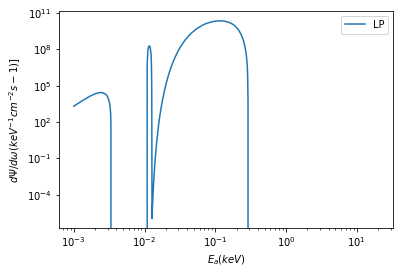

In [8]:
plt.figure()

plt.loglog()

plt.plot(omega_vals,dPhi_pl_seismic,label='LP')

plt.legend()

plt.xlabel(r'$E_a(keV)$')
plt.ylabel(r'$d\Psi/d\omega (keV^{-1}cm^{-2}s-1^{})$]')

#plt.axis([1e-3, 1, 1e33, 1e43])


In [9]:
# Primakoff flux
nfine = 500
costh = np.linspace(-1,0.999,nfine)


gag = 1e-10 # GeV^-1
gag_keV = gag/1e6


nrvals = np.size(r)
r_keV = r*Rsol_keV

nvals = 1000
omega_vals = np.logspace(-3,np.log10(20.0),nvals) # keV
dPhi_P = np.zeros(shape=nvals)
for i_w in range(0,nvals):
    ka = omega_vals[i_w]
    w = omega_vals[i_w]
    Gam = np.zeros(shape=nrvals)
    for i_r in range(0,nrvals):
        if w>wp[i_r]:
            kphoton = np.sqrt(w**2.0-wp[i_r]**2.0)
            x = (ka**2.0+kphoton**2.0)/(2*ka*kphoton)
            y = x + k_S[i_r]**2.0/(2*ka*kphoton)
            Gam[i_r] = (gag_keV**2.0*k_S[i_r]**2.0*T[i_r]/(64*np.pi))*np.trapz((1-costh**2.0)/((x-costh)*(y-costh)),costh)
    Gam *= keV_2_s
    dPhi_P[i_w] = (1.0/(AU_cm**2.0))*(w/np.pi)**2.0*np.trapz(r_keV**2.0*Gam/(np.exp(w/T)-1),r_keV)


/Users/andreacaputo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in exp


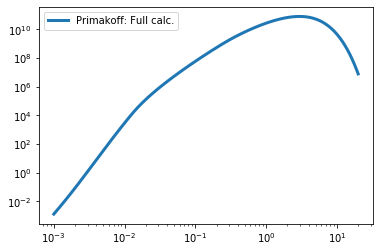

In [10]:
plt.loglog(omega_vals,dPhi_P,lw=3,label='Primakoff: Full calc.')

plt.legend()

In [11]:
# Let's now define the number of photon with and without smearing 
tempo = 3*3600*24*365 # 3 years in s, time of exposure 
Biaxo = 2.5 * fromGtokeV2

# Note: Ea should be given as an array for the function that calculates the plasmon flux
# Note : there is no g here, there should be a g^4 added of course 

def Nphoton(Ea, Brad, ma):
    
    return tempo* epsilonD * epsilonT * S * ProbabilityOfConversion(Ea, Biaxo, ma) * LplasmonFlux(Ea,r,Brad,T,k_S,wp)

# Let's define an array of energies again 

omega_array = np.logspace(-4, -0.5, num = 200)

def Nphoton_array(Brad,ma):
    
    return Nphoton(omega_array, Brad, ma)

def SmearingN(Ea, Brad, ma, resolution):
    
    size = np.size(Ea)
    flux = Nphoton(Ea, Brad, ma)
    newflux = np.zeros(size)
    
    for i in range(size):
        spread = np.abs(Ea[i] - Ea)
        rescale = 1 /(resolution * np.sqrt(2*np.pi)) * np.exp(-(spread)**2/2/resolution**2)
        newflux[i] = np.trapz(rescale * flux, Ea)
    
    newflux = newflux * np.trapz(flux,Ea) / np.trapz(newflux,Ea)
        
    return newflux


In [12]:
try_flux = Nphoton(omega_array, 1e7, 1e-6)
try_flux_smeared = SmearingN(omega_array, 1e7, 1e-6, 1e-2) 

[0.0001, 1, 1e-08, 100000.0]

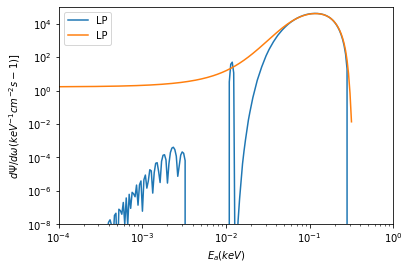

In [13]:
plt.figure()

plt.loglog()

plt.plot(omega_array, (1e-2 * gagkeV)**4 * try_flux,label='LP')
plt.plot(omega_array, (1e-2 * gagkeV)**4 * try_flux_smeared,label='LP')


plt.legend()

plt.xlabel(r'$E_a(keV)$')
plt.ylabel(r'$d\Psi/d\omega (keV^{-1}cm^{-2}s-1^{})$]')

plt.axis([1e-4, 1, 1e-8, 1e5])

# FORGET ABOUT NORMALIZATION, THERE IS NO G THERE 